# Search Engine

## Building a Complete AI Based Search Engine with Elasticsearch, Kubeflow and Katib

Building search systems is hard. Preparing them to work with machine learning is really hard. Developing a complete search engine framework integrated with AI is really really hard.
So let’s make one. ✌️

In this post, we’ll build a search engine from scratch and discuss on how to further optimize results by adding a machine learning layer using Kubeflow and Katib. This new layer will be capable of retrieving results considering the context of users and is the main focus of this article.

As we’ll see, thanks to Kubeflow and Katib, final result is rather quite simple, efficient and easy to maintain.

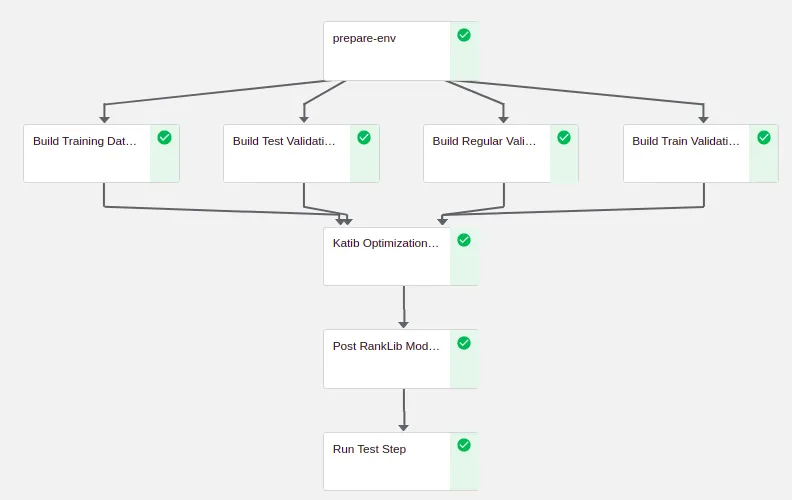
##### Complete pipeline executed by Kubeflow, responsible for orchestrating the whole system. Image by author.

To understand the concepts in practice, we’ll implement the system with hands-on experience. As it’s been built on top of Kubernetes, you can use any infrastructure you like (given appropriate adaptations). We’ll be using Google Cloud Platform (GCP) in this post.

We begin with a brief introduction to concepts and then move to the system implementation discussion.

## 1.You Know, For Search

If you receive the challenge of building a search system for your company or want to build one for your own, you’ll soon realize that the initial steps tend to be somewhat straightforward.

First and foremost, the search engine must contain documents for retrieval. As we’ll be working with Elasticsearch, let’s use it as reference (for an introduction, please refer to their [Official Docs](https://www.elastic.co/guide/en/elasticsearch/guide/current/index.html)

Documents should be uploaded to Elasticsearch following a JSON format. If, for instance, we are building a search engine for a fashion eCommerce store, here’s an example of a document:

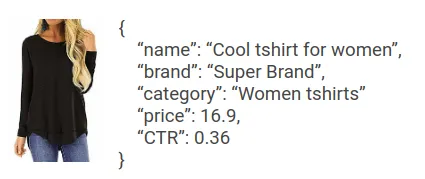

Then comes the retrieval step which in essencenvolves matching search queries with document fields:

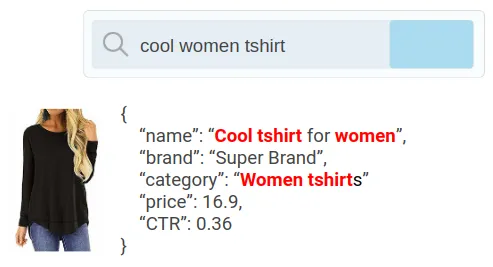

<font size="1.9">Example of document as uploaded to Elasticsearch. Image by author.</font>

The ranking phase applies some mathematical rules such as [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) or [BM25F](https://en.wikipedia.org/wiki/Okapi_BM25) to figure out how to properly rank, sorting documents from best to worst match. It’d be something like:

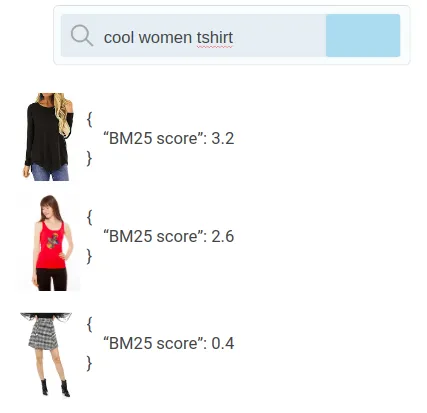

<font size="1.9">Example of properly ranked results as retrieved by Elasticsearch running BM25 scoring among the stored documents in the database. Image by author.</font>

Further optimization could leverage on specific fields of documents containing performance metrics. For instance, in the previous example, we have that the **Click Through Rate** (CTR, i.e., reason between clicks and total impressions) of the t-shirt is *CTR=0.36*. Another retrieval layer could be added using this information and favoring documents with better CTR to show at the top (also known as *“boosting”*):

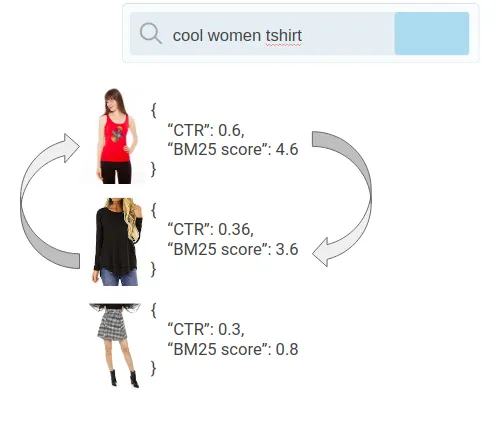
<font size="1.9">Example adding performance metrics layer in retrieval rules. Previous second-best document raises to the top of the results. Image by author.</font>



So far so good. But let’s see how to further optimize even more.

Consider that each user has a specific context. Let’s take our fashion online store as an example again. Some of the traffic may come from southern regions where it may be warmer than regions from the north. They’d probably rather be exposed to lighter clothing than to winter specific products.

More context can be added to the equation: we could distinguish customers based on their favorite brands, categories, colors, sizes, device used, average consuming ticket, profession, age and the list goes on and on…

Doing so requires some extra tools as well. Let’s dive a bit deeper into that.

# 2. The Machine Learning Layer
Learn-to-rank[ (LTR](https://en.wikipedia.org/wiki/Learning_to_rank)) is a field of machine learning that studies algorithms whose main goal is to properly rank a list of documents.

It works essentially as any other learning algorithm: it requires a training dataset, suffers from problems such [as bias-varia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)nce, each model has advantages over certain scenarios and so on.

What basically changes is that the cost function for the training process is designed to let the algorithm learn about ranking and the output of the model is a value for how good of a match a given document is for a given query.

#### Mathematically, it’s simply given by:

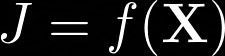

'X' in our case comprehends all features we’d like to use to add context to the search. They can be values such as region of the user, their age, favorite brand, correlation between queries and documents fields and so on.

f is the ranking model which is supposed to be trained and evaluated.

Finally, J extends for Judgment and for us it’s an integer value that ranges from 0 (meaning the document is not a good match for a query given features) up to 4 (document is a very good match). We arrange documents from best to worst by using the judgments.

Our main goal is to obtain f since it represents the ranking algorithm that adds the machine learning layer to the search results. And in order to obtain f, we need a dataset that already contains the values of the judgments otherwise we can’t train the models.

As it turns out, finding those values can be quite challenging. While the details of how to do so won’t be covered here, this post has a thorough discussion on the subject; in a nutshell, we use clickstream data of users interactions with search engines (their clicks and purchases) to fit models whose variables yield a proxy for the judgment value.

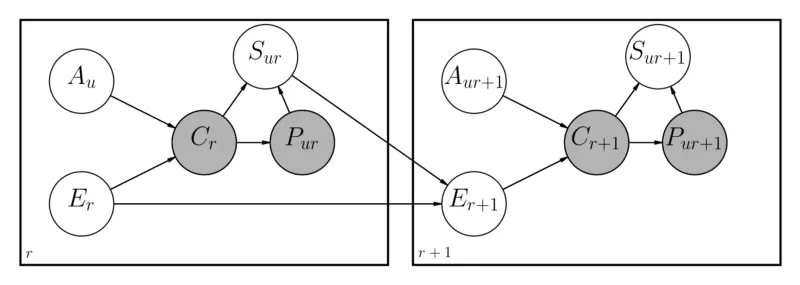

Example of Graphical Model implemented on pyClickModels for finding relevance of documents associated to search engines results. Image by author.


After computing the judgments, we are left with training the ranking models. Elasticsearch already offers a [learn-to-rank](https://github.com/o19s/elasticsearch-learning-to-rank) plugin which we’ll use in this implementation. The plugin offers various ranking algorithms ranging from decision trees to neural networks.

#### This is an example of the required training file:

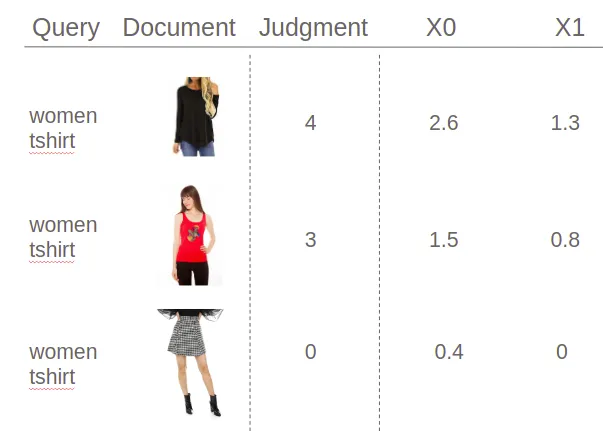
<font size="1.9">Example of input file for the training step as required by Elasticsearch Learn2Rank plugin.</font>

The idea is to register for each query (“women t-shirt”) all documents that were printed in the results page. For each, we compute their expected judgment and build the matrix of features 'X'.

In practice, what will happen is that we’ll first prepare all this data and feed it to the Learn-To-Rank plugin of Elasticsearch which will result in a trained ranking model. It can then be used to add the personalization layer we are looking for.

Further details on building X will be discussed soon.

We are ready now to train the models. So far so good. But then, we still have a tricky problem: how to know if it’s working?

# 2.1 The Valuation Framework
We could choose from several methods to check the performance of a ranking model. The one we’ll discuss here is the average rank metric based on what users either clicked or purchased (pySearchML focuses on purchase events only but clicks can be used interchangeably).

#### Mathematically, it’s given by:

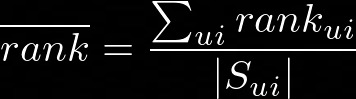

The formula basically sums over each rank associated to each purchased (or clicked) item in reference to a complete list of documents. The denominator is simply the cardinality of how many items were summed over in the process (total items users either clicked or bought).

In practice, what will happen is that, after training a ranking model, we’ll loop through the validation dataset (which contains what users searched and what they purchased) and use each search term to send a query to Elasticsearch. We then compare the results with what users bought to compute the appropriate average ranking.

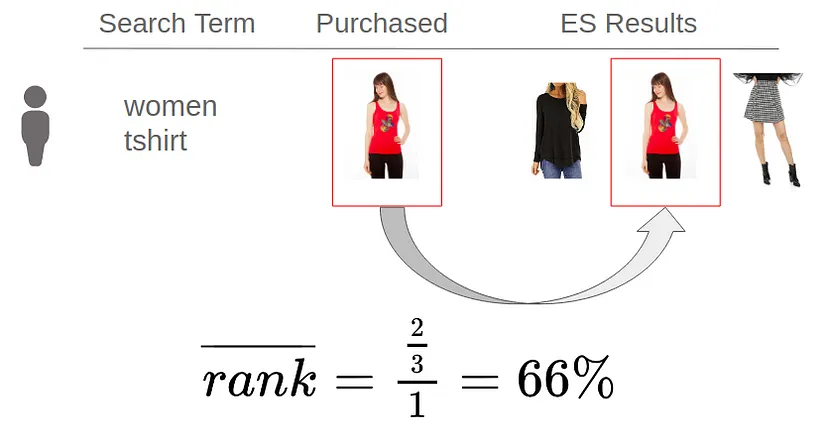

<font size="1.9">Example of the validation framework in practice. For each user in dataset, we use their search term to retrieve from ES results with the ranking model already implemented. We then take the average rank of the purchased items by users and their position in the ES result.</font>


The image above illustrates the concept. For each user, we send their search term to Elasticsearch which already contains the just recently trained model. We then compare the search results with what the user purchased and compute the rank. In the previous example, the red t-shirt appears at position 2 out of the 3 retrieved items. As it’s just one item that was purchased then rank=66%.

We run the same computation to all users in the database and then average them all together for a final rank expression.

Notice that the final rank metric must be lower than 50% otherwise the algorithm is just performing as a random selector of documents.

This value is important as it’s used for selecting the best ranking model. That’s where we use Katib from Kubeflow.

Let’s see now how to put all these concepts together and build the search engine:

# 3. Kubeflow Orchestration
As discussed before, Kubeflow is the orchestrator for the pipeline processing. It has various responsibilities ranging from preparing data for Elasticsearch and for training to running the entire training process.

It works by defining components and their respective tasks. For pySearchML, here’s the complete pipeline that was implemented:

The pipeline is defined by receiving various input parameters such as the bucket and model_name and we’ll be able to change those values at execution time (as we’ll see soon).

In [ ]:
@dsl.pipeline()
def build_pipeline(
    bucket='pysearchml',
    es_host='elasticsearch.elastic-system.svc.cluster.local:9200',
    force_restart=False,
    train_init_date='20160801',
    train_end_date='20160801',
    validation_init_date='20160802',
    validation_end_date='20160802',
    test_init_date='20160803',
    test_end_date='20160803',
    model_name='lambdamart0',
    ranker='lambdamart',
    index='pysearchml'
):
    pvc = dsl.PipelineVolume(pvc='pysearchml-nfs')

    prepare_op = dsl.ContainerOp(
        name='prepare env',
        image=f'gcr.io/{PROJECT_ID}/prepare_env',
        arguments=[f'--force_restart={force_restart}', f'--es_host={es_host}', f'--bucket={bucket}', f'--model_name={model_name}'],
        pvolumes={'/data': pvc}
    )

    val_reg_dataset_op = dsl.ContainerOp(
        name='validation regular dataset',
        image=f'gcr.io/{PROJECT_ID}/data_validation',
        arguments=[f'--bucket={bucket}/validation/regular', f'--validation_init_date={validation_init_date}', f'--validation_end_date={validation_end_date}', f'--destination=/data/pysearchml/{model_name}/validation_regular'],
        pvolumes={'/data': pvc}
    ).set_display_name('Build Regular Validation Dataset').after(prepare_op)

    val_train_dataset_op = dsl.ContainerOp(
        name='validation train dataset',
        image=f'gcr.io/{PROJECT_ID}/data_validation',
        arguments=[f'--bucket={bucket}/validation/train', f'--validation_init_date={train_init_date}', f'--validation_end_date={train_end_date}', f'--destination=/data/pysearchml/{model_name}/validation_train'],
        pvolumes={'/data': pvc}
    ).set_display_name('Build Train Validation Dataset').after(prepare_op)

    val_test_dataset_op = dsl.ContainerOp(
        name='validation test dataset',
        image=f'gcr.io/{PROJECT_ID}/data_validation',
        arguments=[f'--bucket={bucket}/validation/test', f'--validation_init_date={test_init_date}', f'--validation_end_date={test_end_date}', f'--destination=/data/pysearchml/{model_name}/validation_test'],
        pvolumes={'/data': pvc}
    ).set_display_name('Build Test Validation Dataset').after(prepare_op)

    train_dataset_op = dsl.ContainerOp(
        name='train dataset',
        image=f'gcr.io/{PROJECT_ID}/data_train',
        command=['python', '/train/run.py'],
        arguments=[f'--bucket={bucket}', f'--train_init_date={train_init_date}', f'--train_end_date={train_end_date}', f'--es_host={es_host}', f'--model_name={model_name}', f'--index={index}', f'--destination=/data/pysearchml/{model_name}/train'],
        pvolumes={'/data': pvc}
    ).set_display_name('Build Training Dataset').after(prepare_op)

    katib_op = dsl.ContainerOp(
        name='pySearchML Bayesian Optimization Model',
        image=f'gcr.io/{PROJECT_ID}/model',
        command=['python', '/model/launch_katib.py'],
        arguments=[f'--es_host={es_host}', f'--model_name={model_name}', f'--ranker={ranker}', '--name=pysearchml', f'--train_file_path=/data/pysearchml/{model_name}/train/train_dataset.txt', f'--validation_files_path=/data/pysearchml/{model_name}/validation_regular', '--validation_train_files_path=/data/pysearchml/{model_name}/validation_train', f'--destination=/data/pysearchml/{model_name}/'],
        pvolumes={'/data': pvc}
    ).set_display_name('Katib Optimization Process').after(
        val_reg_dataset_op, val_train_dataset_op, val_test_dataset_op, train_dataset_op
    )

    post_model_op = dsl.ContainerOp(
        name='Post Best RankLib Model to ES',
        image=f'gcr.io/{PROJECT_ID}/model',
        command=['python', '/model/post_model.py'],
        arguments=[f'--es_host={es_host}', f'--model_name={model_name}', f'--destination=/data/pysearchml/{model_name}/best_model.txt'],
        pvolumes={'/data': pvc}
    ).set_display_name('Post RankLib Model to ES').after(katib_op)

    _ = dsl.ContainerOp(
        name='Test Model',
        image=f'gcr.io/{PROJECT_ID}/model',
        command=['python', '/model/test.py'],
        arguments=[f'--files_path=/data/pysearchml/{model_name}/validation_test', f'--index={index}', f'--es_host={es_host}', f'--model_name={model_name}'],
        pvolumes={'/data': pvc}
    ).set_display_name('Run Test Step').after(post_model_op)

#### Let’s see each component from the pipeline implementation and its purpose:
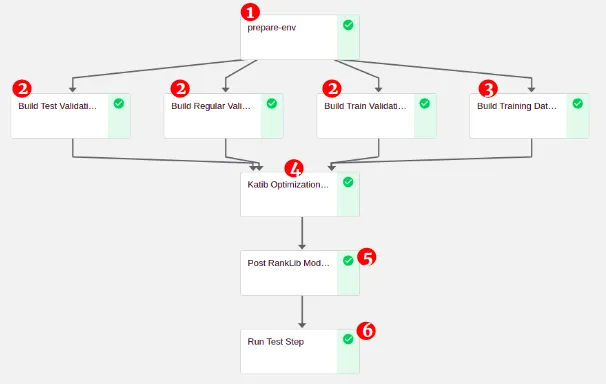
<font size="1.9">Step-by-step as implemented in pySearchML. Image by author.</font>


## 1. Prepare_Env
Here’s how prepare_env component is defined:

In [ ]:
prepare_op = dsl.ContainerOp(
    name='prepare env',
    image=f'gcr.io/{PROJECT_ID}/prepare_env',
    arguments=[f'--force_restart={force_restart}', f'--es_host={es_host}', f'--bucket={bucket}', f'--model_name={model_name}'],
    pvolumes={'/data': pvc}
)

*Image* is a docker reference for the component to run in that step.
*Arguments* are input parameters sent to the script executed in the Docker’s image ENTRYPOINT.
*pvolumes* mounts the volume claim into \data.

## Here’s all files in prepare_env:
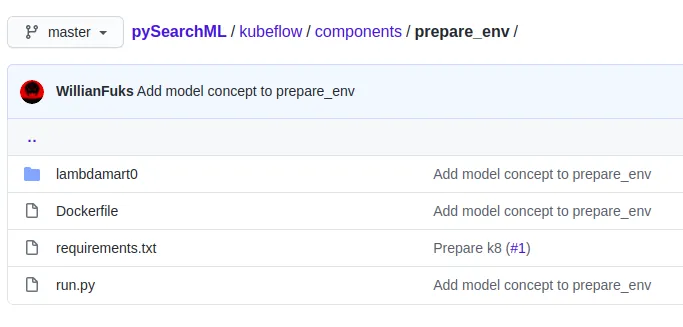

*run.py* is responsible for running queries against [BigQuery](https://cloud.google.com/bigquery) and preparing Elasticsearch. One of its input arguments is *model_name* which sets which folder to use as reference for processing data. *lambdamart0* is an algorithm that has already implemented to work with **Google Analytics(GA)** [Public sample](https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data?filter=category%3Aanalytics&id=45f150ac-81d3-4796-9abf-d7a4f98eb4c6&project=pysearchml&folder=&organizationId=) dataset.
*Dockerfile* bundles the whole code together and have as *ENTRYPOINT* the execution of the *run.py* script:

In [ ]:
FROM python:3.7.7-alpine3.12 as python

COPY kubeflow/components/prepare_env /prepare_env
WORKDIR /prepare_env
COPY ./key.json .

ENV GOOGLE_APPLICATION_CREDENTIALS=./key.json

RUN pip install -r requirements.txt

ENTRYPOINT ["python", "run.py"]

*lambdamart0* is a folder dedicated to an implementation of an algorithm with this respective name. It’s been built to process **GA public** data and works as an example of the system. Here’s the files it contains:

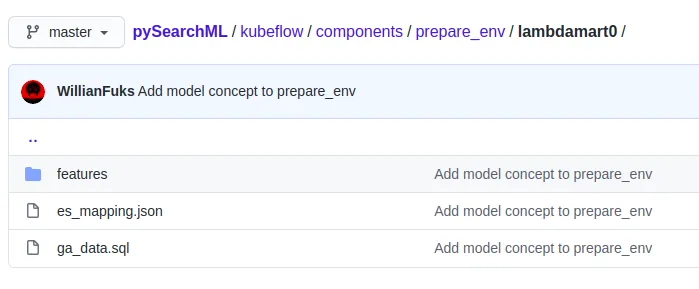

*ga_data.sql* is a query responsible for retrieving documents from the **GA public** dataset and exporting it to Elasticsearch
*es_mapping.json* is an index definition for each field of the documents
features carries the value of X as discussed before. In *lambdamart0* example, it uses the **GA public** data as reference for building the features.
Notice the feature called *name.json*:

In [ ]:
{
   "query": {
       "bool": {
           "minimum_should_match": 1,
           "should": [
               {
                   "match": {
                       "name": "{{search_term}}"
                   }
               }
           ]
       }
    },
    "params": ["search_term"],
    "name": "BM25 name"
}

It receives as input the parameter channel_group (channel that brought the user to our web store) and returns the CTR for that respective channel.

This effectively prepares the model to distinguish from users their origin and how to rank each group. Specifically, users coming from paid sources might behave differently than those coming in through organic channels for instance. If the training is good enough, the ranking algorithm should be prepared to handle these situations.

Still, this doesn’t tell much on how to personalize results by using intrinsic characteristics of each user. So, here’s one possibility for solving that. The feature *avg_customer_price.json* is defined as:

In [ ]:
{
    "query": {
        "function_score": {
            "query": {
                "match_all": {}
            },
            "script_score" : {
                "script" : {
                    "params": {
                        "customer_avg_ticket": "{{customer_avg_ticket}}"
                    },
                    "source": "return Math.log(1 + Math.abs(doc['price'].value - Float.parseFloat(params.customer_avg_ticket)))"
                }
            }
        }
    },
    "params": ["customer_avg_ticket"],
    "name": "customer_avg_ticket"
}

It receives as input the parameter *customer_avg_ticke* and returns for each document the log of the distance between the average user ticket and the price of the document.

Now the ranking model can learn in the training phase how to manage the rank of each item based on how distant its price is to the average spending of the user on the website.

With those three types of features we can add a complete personalization layer to a search system on top of Elasticsearch. Features can be anything as long as it can be abstracted into a valid search query and they must return some scoring metric eventually translated as our value **'X'**.

For what follows in *prepare_env* component:

Features are exported to Elasticsearch.
An index is created on Elasticsearch that defines documents fields.
Documents are queried from [BigQuery](https://cloud.google.com/bigquery) and uploaded into Elasticsearch.
[RankLib requirements](https://github.com/WillianFuks/pySearchML/blob/master/kubeflow/components/prepare_env/run.py#L184:L185) are created (feature set store and so on).

For implementing a new model with new data and features, just create another folder inside *prepare_env* (something like *modelname2*) and set how it will query data and upload them to Elasticsearch.

## 2. Validation Datasets
This is a simple step. It consists of retrieving data from BigQuery containing what users searched, the context of the search and a list of products purchased.

Here’s the BigQuery query used for retrieving the data. It basically selects all users, their searches and purchases and then combines with their context. An example of the results:

In [ ]:
{
  "search_keys": {
    "search_term": "office",
    "channel_group": "direct",
    "customer_avg_ticket": "13"
  },
  "docs": [
    {"purchased":["GGOEGOAQ012899"]}
  ]
}

*search_keys* can contain any available information that sets the context of customers. In the previous example, we’re using their channel group and average spending ticket on the website.

This data is what we feed into the validation framework when computing the average rank as discussed before.

Notice that the system builds three different validation datasets: one for the training period, another for the regular validation and finally the third is for the final testing step. The idea here is to analyze bias and variance for the trained models.

## 3. Training Dataset
This is the component responsible for building the RankLib training file as discussed before. The complete [script](https://github.com/WillianFuks/pySearchML/blob/master/kubeflow/components/data/train/run.py) is actually quite simple. First, it downloads from BigQuery the input clickstream data which consists of users interactions on search pages. Here’s an example:

In [ ]:
{
  "search_keys": {
    "search_term": "drinkware",
    "channel_group": "direct",
    "customer_avg_ticket": "20"
  },
  "judgment_keys": [
    {
      "session": 
        [
          {"doc":"GGOEGDHC017999","click":"0","purchase":"0"},
          {"doc":"GGOEADHB014799","click":"0","purchase":"0"},
          {"doc":"GGOEGDHQ015399","click":"1","purchase":"0"}
        ]
    }
  ]
}

Notice that the keys associated to the search are aggregated together inside *search_keys*. Those values are the ones we send to Elasticsearch and replace appropriately each feature**X** as discussed in *prepare_env*. In the previous **JSON** example, we know that the user search context is:

Searched for *drinkware*.
Came to the store directly.
Spent on average $20 on the website.

*judgment_keys* combines users sessions composed of documents they saw on the search page and their interaction on a given document.

This information is then sent to [pyClickModels](https://github.com/WillianFuks/pyClickModels) which then process the data and evaluates the judgment for each query-document pair. Result is a newline delimited JSON document as follows:

In [ ]:
{
  "search_term: bags|channel_group:organic_search|customer_avg_ticket:30": {
    "GGOEGBRJ037299": 0.3333377540111542,
    "GGOEGBRA037499": 0.222222238779068,
    "GGOEGBRJ037399": 0.222222238779068
  }
}

Notice that the value of the key is *search_term:bags|channel_group:organic|customer_avg_ticket:30.*

As discussed before, we want our search engine to be aware of context and further optimize on top of that. As a consequence, judgments are extract based on the entire selected context, not just the search_term.

By doing so, we can differentiate documents for each context and we’d have scenarios where a product receives judgment 4 for customers coming from northern regions and judgment 0 otherwise, as an example.

Notice that the judgments values, as given by *pyClickModels*, ranges between 0 and 1. As the Learn-To-Rank Elasticsearch plugin is built on top of RankLib, this value is expected to range between integers 0 and 4, inclusive. What we do then is we transform the variables using their percentile as reference. Here’s the complete code for building the final judgment files:



In [ ]:
def build_judgment_files(model_name: str) -> None:
    model = DBN.DBNModel()
    clickstream_files_path = f'/tmp/pysearchml/{model_name}/clickstream/'
    model_path = f'/tmp/pysearchml/{model_name}/model/model.gz'
    rmtree(os.path.dirname(model_path), ignore_errors=True)
    os.makedirs(os.path.dirname(model_path))
    judgment_files_path = f'/tmp/pysearchml/{model_name}/judgments/judgments.gz'
    rmtree(os.path.dirname(judgment_files_path), ignore_errors=True)
    os.makedirs(os.path.dirname(judgment_files_path))

    model.fit(clickstream_files_path, iters=10)
    model.export_judgments(model_path)

    with gzip.GzipFile(judgment_files_path, 'wb') as f:
        for row in gzip.GzipFile(model_path):
            row = json.loads(row)
            result = []
            search_keys = list(row.keys())[0]
            docs_judgments = row[search_keys]
            search_keys = dict(e.split(':') for e in search_keys.split('|'))
            judgments_list = [judge for doc, judge in docs_judgments.items()]

            if all(x == judgments_list[0] for x in judgments_list):
                continue

            percentiles = np.percentile(judgments_list, [20, 40, 60, 80, 100])

            judgment_keys = [{'doc': doc, 'judgment': process_judgment(percentiles, judgment)}
                             for doc, judgment in docs_judgments.items()]
            result = {'search_keys': search_keys, 'judgment_keys': judgment_keys}
            f.write(json.dumps(result).encode() + '\n'.encode())

            
def process_judgment(percentiles: list, judgment: float) -> int:
    if judgment <= percentiles[0]:
        return 0
    if judgment <= percentiles[1]:
        return 1
    if judgment <= percentiles[2]:
        return 2
    if judgment <= percentiles[3]:
        return 3
    if judgment <= percentiles[4]:
        return 4

### Here’s an example of the output of this step:

In [ ]:
{
  "search_keys": {
    "search_term": "office",
    "channel_group": "organic_search",
    "customer_avg_ticket": "24"
  },
  "judgment_keys": [
    {"doc": "0", "judgment": 0},
    {"doc": "GGOEGAAX0081", "judgment": 4},
    {"doc": "GGOEGOAB016099", "judgment": 0}
  ]
}

This data needs to be transformed into the required training file for RankLib. This is where we combine the information of judgments, documents, queries context with the features **X** (here’s the [code](https://github.com/WillianFuks/pySearchML/blob/master/kubeflow/components/data/train/run.py#L124) example for retrieving X from Elasticsearch).

Each JSON row from previous step containing search context and judgment keys is looped over and sent as a query against Elasticsearch with the input parameters of the *search_keys*. The result will be each value of **X** as already defined from previous *prepare_env* step.

End result is a training file that looks something like this:

In [ ]:
0	qid:0	1:3.1791792	2:0	3:0.0	4:2.3481672
4	qid:0	1:3.0485907	2:0	3:0.0	4:2.3481672
0	qid:0	1:3.048304	2:0	3:0.0	4:0
0	qid:0	1:2.9526825	2:0	3:0.0	4:0
4	qid:1	1:2.7752903	2:0	3:0.0	4:3.61228
0	qid:1	1:2.8348017	2:0	3:0.0	4:2.3481672

For each query and for each document we have the estimated judgment as computed by *pyClickModels*, the id of the query and then a list of features X with their respective values.

With this file, we can train now the ranking algorithms.

## 4. Katib Optimization
[Katib](https://github.com/kubeflow/katib) is a tool from Kubeflow that offers an interface for automatic hyperparameter optimization. It has several available methods; Bayesian Optimization is the one selected in pySearchML.



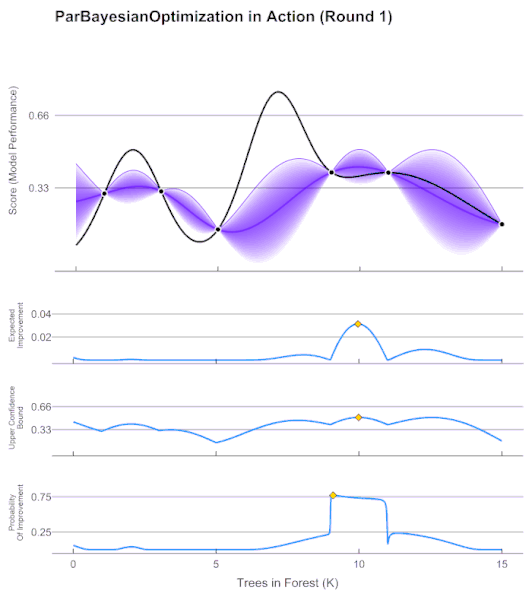

<font size="1">Example of the algorithm Bayesian Optimization. As it samples more data points from the allowed domain, the closer it may get to the optimum value of a given function. In pySearchML, the domain is a set of variables that sets how a ranker should fit the data and the cost function it’s optimizing is the average rank. Image taken from Wikimedia Foundation.</font>

What Katib does is it selects for each hyperparameter a new value based on a trade-off between [exploration-exploitation.](https://en.wikipedia.org/wiki/Bayesian_optimization) It then tests the new model and observe results which are used for future steps.

For *pySearchML*, each parameter is an input of [RankLib](https://sourceforge.net/p/lemur/wiki/RankLib%20How%20to%20use/) which sets how the model will be fit (such as how many trees to use, total leaf nodes, how many neurons in a net and so on).

Katib is defined through a [Custom Resource](https://kubernetes.io/docs/concepts/extend-kubernetes/api-extension/custom-resources/) of Kubernetes. We can run it by defining a YAML file and deploying it to the cluster, something like:

***kubectl create -f katib_def.yaml***

What Katib will do is read through the **YAML** file and start [trials](https://github.com/kubeflow/katib), each experimenting a specific value of hyperparameters. It can instantiate multiple pods running in parallel executing the code as specified in the experiment definition.

Here are the files in this step:

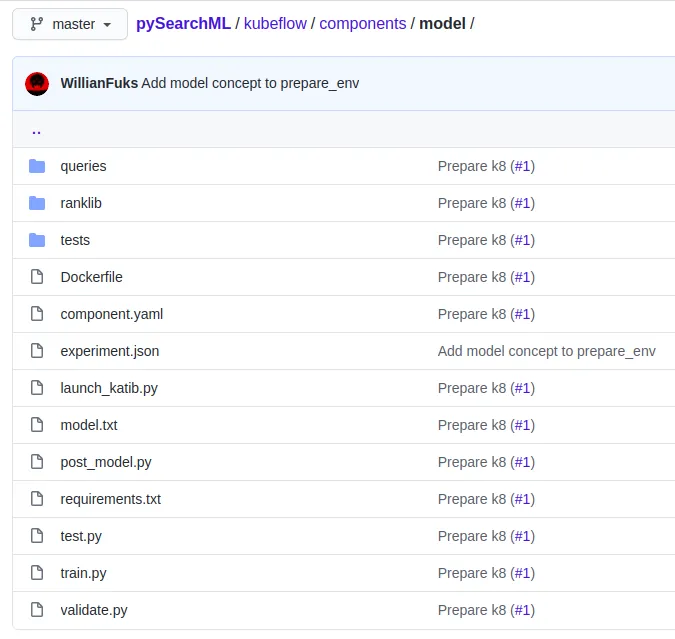


*launch_katib.py* is responsible for launching Katib from a Python script. It receives input arguments, builds an YAML definition and use Kubernetes APIs to start Katib from the script itself.

*experiment.json* works as a template for the definition of the experiment. Here’s its definition:

In [ ]:
{
  "apiVersion": "kubeflow.org/v1alpha3",
  "kind": "Experiment",
  "metadata": {
    "namespace": "kubeflow",
    "name": "",
    "labels": {
      "controller-tools.k8s.io": "1.0"
    }
  },
  "spec": {
    "objective": {
      "type": "minimize",
      "objectiveMetricName": "Validation-rank",
      "additionalMetricNames": [
        "rank"
      ]
    },
    "algorithm": {
      "algorithmName": "bayesianoptimization"
    },
    "parallelTrialCount": 1,
    "maxTrialCount": 2,
    "maxFailedTrialCount": 1,
    "parameters": [],
    "trialTemplate": {
      "goTemplate": {
        "rawTemplate": {
          "apiVersion": "batch/v1",
          "kind": "Job",
          "metadata":{
            "name": "{{.Trial}}",
            "namespace": "{{.NameSpace}}"
          },
          "spec": {
            "template": {
              "spec": {
                "restartPolicy": "Never",
                "containers": [
                  {
                    "name": "{{.Trial}}",
                    "image": "gcr.io/{PROJECT_ID}/model",
                    "command": [
                      "python /model/train.py --train_file_path={train_file_path} --validation_files_path={validation_files_path} --validation_train_files_path={validation_train_files_path} --es_host={es_host} --destination={destination} --model_name={model_name} --ranker={ranker} {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                    ],
                    "volumeMounts": [
                      {
                        "mountPath": "/data",
                        "name": "pysearchmlpvc",
                        "readOnly": false
                      }
                    ]
                  }
                ],
                "volumes": [
                  {
                    "name": "pysearchmlpvc",
                    "persistentVolumeClaim": {
                      "claimName": "pysearchml-nfs",
                      "readOnly": false
                    }
                  }
                ]
              }
            }
          }
        }
      }
    }
  }
}

It essentially defines how many pods to run in parallel and which Docker image to run for each trial along with its input command. Notice that the total pods running in parallel as well as maximum trials are hard-coded in *pySearchML*. Best approach would be to receive those parameters from the pipeline execution and replace them accordingly.

*launch_katib.py* will read this template, build a final **YAML** definition and send it to Kubernetes which will start the Katib process.

One of the input parameters is the *ranker* which is the ranking algorithm to select from RankLib (such as lambdaMart, listNet and so on). Each ranker has its own set of parameters, here’s the example for LambdaMart algorithm as implemented in **launch_katib.py:**

In [ ]:
def get_ranker_parameters(ranker: str) -> List[Dict[str, Any]]:
    return {
        'lambdamart': [
            {"name": "--tree", "parameterType": "int", "feasibleSpace": {"min": "1", "max": "500"}},
            {"name": "--leaf", "parameterType": "int", "feasibleSpace": {"min": "2", "max": "40"}},
            {"name": "--shrinkage", "parameterType": "double", "feasibleSpace": {"min": "0.01", "max": "0.2"}},
            {"name": "--tc", "parameterType": "int", "feasibleSpace": {"min": "-1", "max": "300"}},
            {"name": "--mls", "parameterType": "int", "feasibleSpace": {"min": "1", "max": "10"}}
        ]
    }.get(ranker)

Katib will select parameters from the domain defined above and run train.py where effectively RankLib is used to train the ranking models. An example of the command as implemented in Python:

In [ ]:
cmd = ('java -jar ranklib/RankLib-2.14.jar -ranker '
       f'{ranker} -train {args.train_file_path} -norm sum -save '
       f'{args.destination}/model.txt '
       f'{(" ".join(X)).replace("--", "-").replace("=", " ")} -metric2t ERR')

This string is sent to a *subprocess* call (notice it requires Java because of RankLib) which starts the training process. The result is a newly trained ranking model that can be exported to Elasticsearch.

Just as the model is fit, [validate.py](https://github.com/WillianFuks/pySearchML/blob/master/kubeflow/components/model/validate.py) is invoked for computing the expected rank. The steps that take place are:

The script loops through each JSON from the validation dataset.
Each row contains the search context which is then used to build an Elasticsearch query. Here’s the query used by the model *lambdamart0* which we’ll use later on:


In [ ]:
{
    "query": {
        "function_score": {
            "query": {
                "bool": {
                    "must": {
                        "bool": {
                            "minimum_should_match": 1,
                            "should": [
                                {
                                    "multi_match": {
                                        "operator": "and",
                                        "query": "{query}",
                                        "type": "cross_fields",
                                        "fields": [
                                            "sku",
                                            "name",
                                            "category"
                                        ]
                                    }
                                }
                            ]
                        }
                    }
                }
            },
            "functions": [
                {
                    "field_value_factor": {
                        "field": "performances.global.CTR",
                        "factor": 10,
                        "missing": 0,
                        "modifier": "none"
                    }
                }
            ],
            "boost_mode": "sum",
            "score_mode": "sum"
        }
    },
    "rescore": {
        "window_size": "{window_size}",
        "query": {
            "rescore_query": {
                "sltr": {
                    "params": "{search_keys}",
                    "model": "{model_name}"
                }
            },
            "rescore_query_weight": 20,
            "query_weight": 0.1,
            "score_mode": "total"
        }
    }
}

Given the recently built query, a request is sent to Elasticsearch.
A comparison happens between the search results and purchased documents.
Here’s the code responsible for building the Elasticsearch query:



In [ ]:
def get_es_query(
    search_keys: Dict[str, Any],
    model_name: str,
    es_batch: int = 1000
) -> str:
    """
    Builds the Elasticsearch query to be used when retrieving data.
    Args
    ----
      args: NamedTuple
        args.search_keys: Dict[str, Any]
            Search query sent by the customer as well as other variables that sets its
            context, such as region, favorite brand and so on.
        args.model_name: str
            Name of RankLib model saved on Elasticsearch
        args.index: str
            Index on Elasticsearch where to retrieve documents
        args.es_batch: int
            How many documents to retrieve
    Returns
    -------
      query: str
          String representation of final query
    """
    # it's expected that a ES query will be available at:
    # ./queries/{model_name}/es_query.json
    query = open(f'queries/{model_name}/es_query.json').read()
    query = json.loads(query.replace('{query}', search_keys['search_term']))
    # We just want to retrieve the id of the document to evaluate the ranks between
    # customers purchases and the retrieve list result
    query['_source'] = '_id'
    query['size'] = es_batch
    query['rescore']['window_size'] = 50  # Hardcoded to optimize first 50 skus
    query['rescore']['query']['rescore_query']['sltr']['params'] = search_keys
    query['rescore']['query']['rescore_query']['sltr']['model'] = model_name
    return query

Notice that the parameter *rescore_query* triggers the machine learning layer on Elasticsearch learn-to-rank plugin.

Finally, the function *compute_rank* puts it all together as shown below:

In [ ]:
def compute_rank(
    search_arr: List[str],
    purchase_arr: List[List[Dict[str, List[str]]]],
    rank_num: List[float],
    rank_den: List[float],
    es_client: Elasticsearch
) -> None:
    """
    Sends queries against Elasticsearch and compares results with what customers
    purchased. Computes the average rank position of where the purchased document falls
    within the retrieved items.
    Args
    ----
      search_arr: List[str]
          Searches made by customers as observed in validation data. We send those
          against Elasticsearch and compare results with purchased data
      purchase_arr: List[List[Dict[str, List[str]]]]
          List of documents that were purchased by customers
      rank_num: List[float]
          Numerator value of the rank equation. Defined as list to emulate a pointer
      rank_den: List[float]
      es_client: Elasticsearch
          Python Elasticsearch client
    """
    idx = 0
    if not search_arr:
        return

    request = os.linesep.join(search_arr)
    response = es_client.msearch(body=request, request_timeout=60)

    for hit in response['responses']:
        docs = [doc['_id'] for doc in hit['hits'].get('hits', [])]

        if not docs or len(docs) < 2:
            continue

        purchased_docs = [
            docs for purch in purchase_arr[idx] for docs in purch['purchased']
        ]
        ranks = np.where(np.in1d(docs, purchased_docs))[0]
        idx += 1

        if ranks.size == 0:
            continue

        rank_num[0] += ranks.sum() / (len(docs) - 1)
        rank_den[0] += ranks.size

    print('rank num: ', rank_num[0])
    print('rank den: ', rank_den[0])

Katib instantiate [sidecars pods](https://www.magalix.com/blog/the-sidecar-pattern) which keeps reading through the stdout of the training pod. When it identifies the string ***Validation-rank=(...)***, it uses the value as the result for the optimization process.

A persistent volume is used in the process to save the definition of the best model trained by Katib which is used by our next component.

## 5. Post RankLib Model
The most difficult parts are done already. Now what happens is the script simply goes after the definition of the best model as saved in a text file and uploads it to Elasticsearch.

Notice that one of the main advantages with this design is that this component could export the model to a production Elasticsearch while the whole optimization could happen on a staging replica engine.

## 6. Final Testing
Finally, as the best model is exported to Elasticsearch, the system has at its disposal the best optimized ranking model. In this step, a final validation is executed in order to verify not only that everything worked fine as well as for providing further information on whether the system is suffering from bias-variance.

That’s pretty much it! Let’s run some code now to see this whole framework in action.

# 4. Hands-On Section
Time to implement the whole architecture in practice! Complete code is available on pySearchML repository:

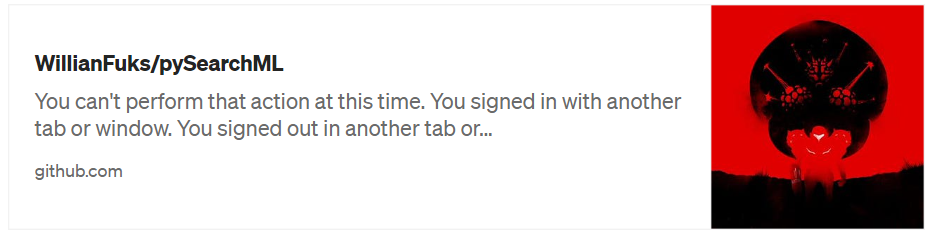

In this section, we’ll be using GCP for running the code with real data. Also, keep in mind that there will be costs (a few cents) associated to running this experiment.

For those new to GCP, there’s a $300 free credit gift that lasts for a year; just [sign in](https://cloud.google.com/getting-started) and create a project for this tutorial (*pysearchml* for instance). You should end up with access to a dashboard that looks like this:

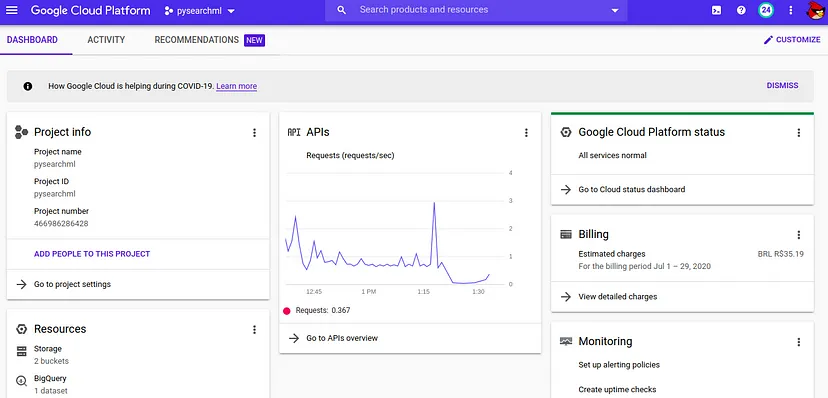

[gcloud](https://cloud.google.com/sdk/install) will be required for interacting with GCP through command line. Installing it is quite straightforward. After the initial setup, make sure you can login by running:

***gcloud auth login***

Now the rest is quite simple. Clone pySearchML to your local:

git clone pysearchml && cd pySearc
h[ML
En](https://console.developers.google.com/apis/library/container.googleapis.com)able Kubernetes Engine in your platform. After that, just trigger the execution[ of cloudb](https://cloud.google.com/cloud-build)uild which will be responsible for creating the whole required infrastructure (this step should take somewhere betwe-n 5~10 minutes).

Here’s ho[w the](https://github.com/WillianFuks/pySearchML/tree/master/kubeflow/build) build triggers the run:



In [ ]:
#!/bin/bash
set -e

SUBSTITUTIONS=\
_COMPUTE_ZONE='us-central1-a',\
_CLUSTER_NAME='pysearchml',\
_VERSION='0.0.0'

./kubeflow/build/manage_service_account.sh

gcloud builds submit --no-source --config kubeflow/build/cloudbuild.yaml --substitutions $SUBSTITUTIONS --timeout=2h

You can choose appropriate values in the variable *SUBSTITUTIONS*. Notice that *_VERSION* sets the pipeline version to be exported to Kubeflow. After everything is set, just run the script:

**./kubeflow/build/build.sh**


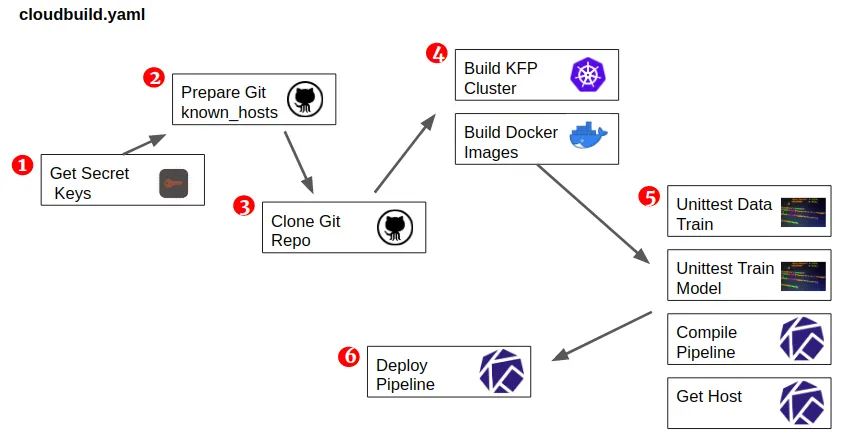


1.Prepares secret keys to allow access and authorization into GCP tools.
2.Prepares known_hosts in building machine.
3.Clones pySearchML locally.
4.The file [*create_k8.sh*](https://github.com/WillianFuks/pySearchML/blob/master/bin/create_k8s.sh) that runs in step 4 is responsible for creating the Kubernetes cluster on top of Google Kubernetes Engine [(GKE)](https://cloud.google.com/kubernetes-engine) as well as deploying Elasticsearch, Kubeflow and Katib. In parallel, all Docker images required for the system is built and deployed to Google Container Registry [(GCR)](https://cloud.google.com/container-registry) for later use in Kubeflow.
5.Run several unittests. Those ended up being important to confirm the system was working as expected. Also, it compiles the Kubeflow pipeline in parallel.
6.Finally, deploys the pipeline to the cluster.

After it’s done, if you browse to your console and select “Kubernetes Engine”, you’ll see that it’s already up and running:

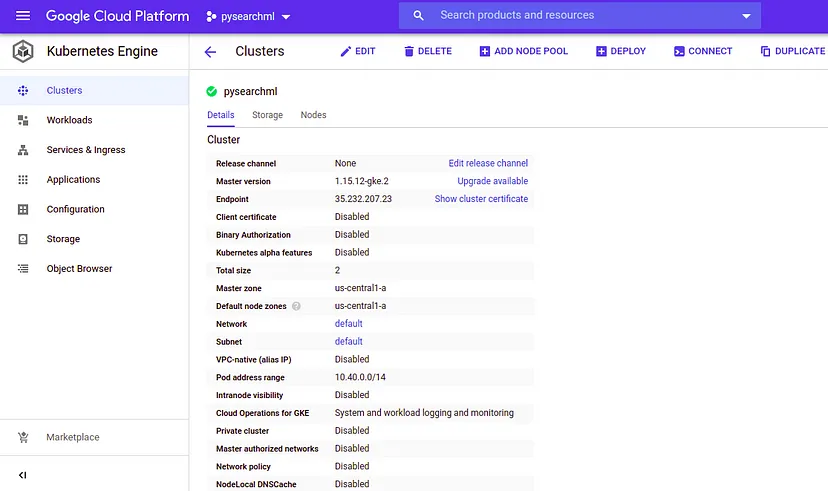

It’s a small cluster as we won’t be using much data, this helps to further save on costs.
Kubeflow and Katib have already been installed. In order to access it, first connect your gcloud to the cluster by running:

***gcloud container clusters get-credentials pysearchml***

After that, port-forward the service that deals with Kubeflow to your local by running:

***kubectl port-forward -n kubeflow svc/ml-pipeline-ui 8080:80 1>/dev/null &***

Now, if you access your localhost on port 8080, this is what you should see:

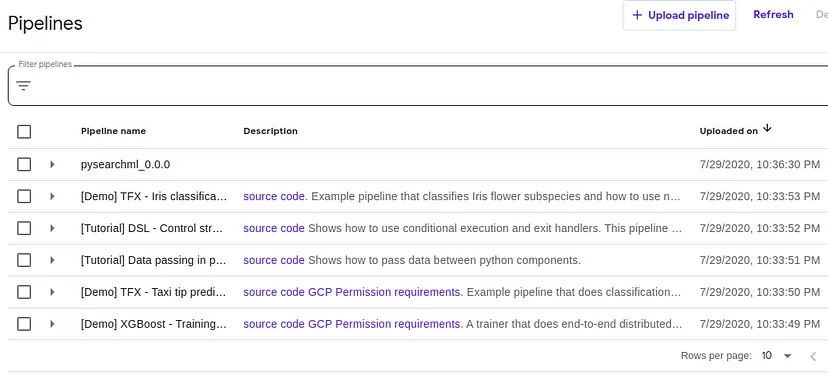

And the pipeline is ready for execution.

This experiment uses the public [Google Analytics sample](https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data?filter=category%3Aanalytics&id=45f150ac-81d3-4796-9abf-d7a4f98eb4c6&project=pysearchml&folder=&organizationId=) dataset and it consists of a small sample of customers browsing on Google Store. It spans from *20160801* up to *20170801* and contains what each user searched and how they interacted with the search results.

Select *pysearchml_0.0.0* and then select “+Create Run”. You should see a screen with all possible input parameters as defined in the Python pipeline script. After choosing appropriate parameters, just run the code.

After execution, here’s the expected result:



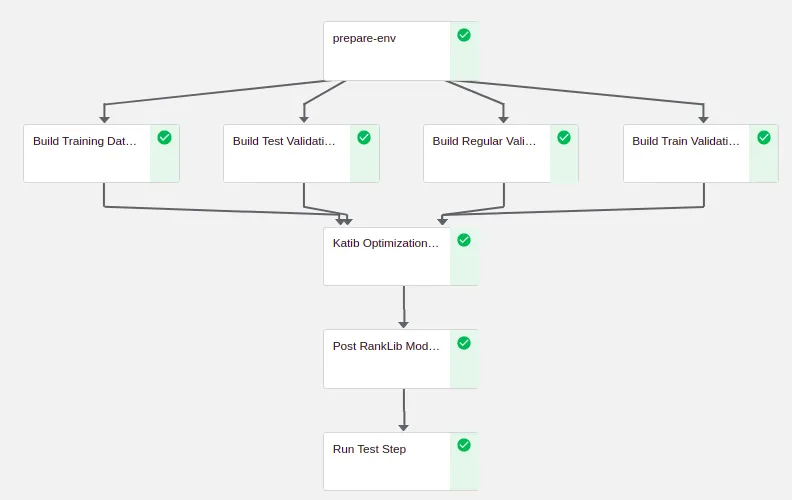

#### Output of Katib component:

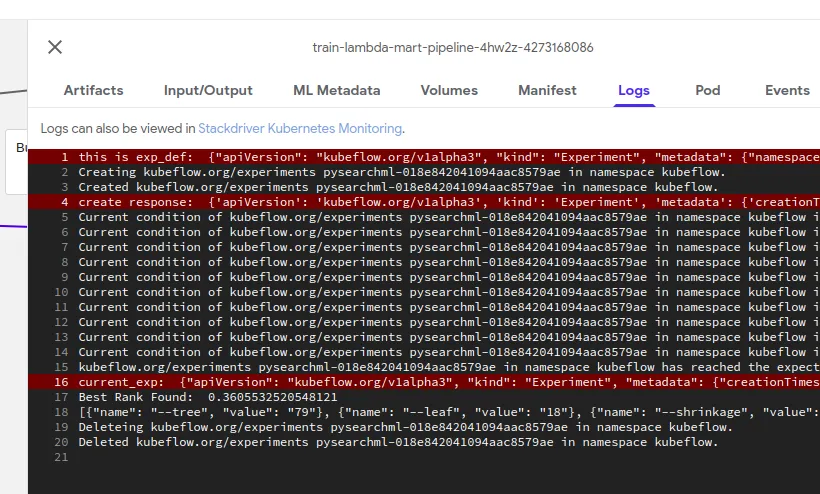


We can see a rank of ***36.05%.*** Then, we can compare results from the test component:



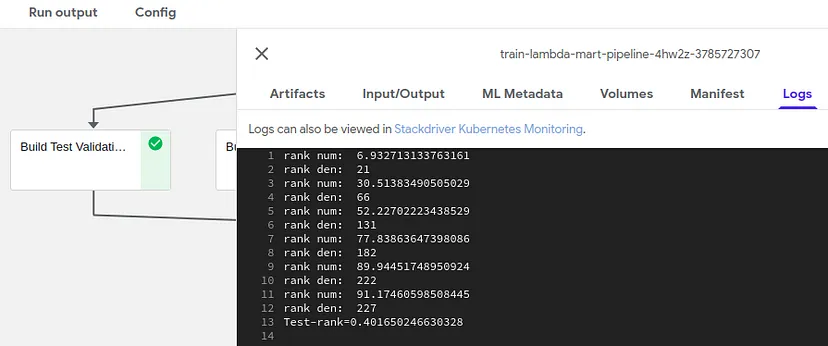

Rank here is *40.16%* which is a bit worse than validation dataset. It might indicate that the model suffers a bit of over fitting; more data or further parameters exploration might help to alleviate this problem.
And, pretty much, there you have it! Elasticsearch now has a fully trained new layer of machine learning to improve results based on context of customers.
If you want to navigate through the files created for each step, there’s an available deployment for that. In the pySearchML folder, just run:

***kubectl apply -f kubeflow/disk-busybox.yaml***

If you run *kubectl -n kubeflow get pods* you’ll see that the name of one of the pods is something like ***“nfs-busybox-(…)”***. If you exec into it you’ll have access to the files:

***kubectl -n kubeflow exec -it nfs-busybox-(...) sh***

They should be located at */mnt/pysearchml.*
There’s also a quick and dirty visualizer for the whole process as well. Just run:

***kubectl port-forward service/front -n front 8088:8088 1>/dev/null &***

And access your browser in *localhost:8088*. You should see this (quick and ugly) interface:



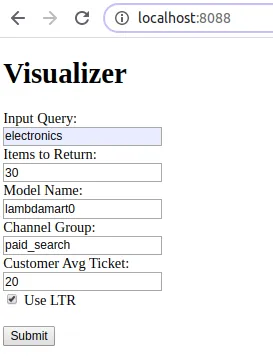

Example of results:

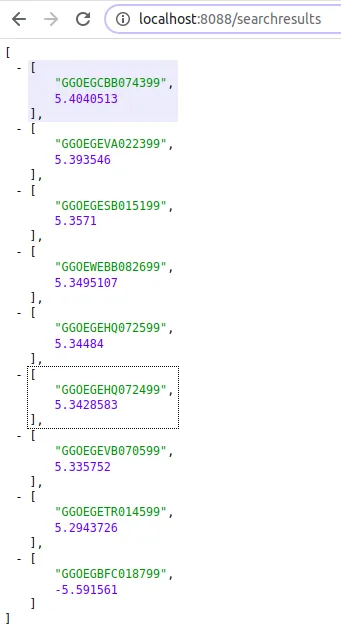

Not only does it allow to play around with results as well as give us a better sense if the optimization pipeline is working or not.

And that’s pretty much all it takes to have a complete search engine running with AI optimization ready to handle income traffic for any store.

# 5. Conclusion
Now, that was a challenge!

Building pySearchML was quite tough and I can safely say it was one of the most brutal challenges I’ve ever faced 😅. Countless and countless designs, architectures, infrastructures were considered but most failed.

The realization of integrating the whole process on top of Kubeflow and Katib came only later on when several alternatives had already been tested.

The advantage of this design is how simple and direct the final code becomes. It’s fully modular, each component is responsible for a simple task and Kubeflow orchestrates the whole execution. On top of that, we can focus mainly in the code development and let Katib do the hard work of finding best parameters.

The development process was not straightforward. Several lessons had to be learned including concepts from Kubernetes and its available resources. Still, it was all well worth it. As a result, an entire search engine could be built from scratch with a few lines of code, ready to handle real traffic.

As next steps, one could probably consider replacing RankLib with some Deep Learning algorithm which would further extract context from data. One of the main challenges for doing so is that the response time of the system could increase as well as the costs (pros and cons have to be evaluated).

Regardless of the ranking algorithm used, the architecture remains the same for the most part.

Hopefully, that was a useful post for those working in this field. Now it’s time for us to take some rest, meditate on the lessons learned and prepare ourselves for the next adventure :).

As for this post, it certainly deserves being concluded with the mission accomplished [soundtrack.](https://open.spotify.com/playlist/6DDVtTmNRo32PUGy3vsRCC)

And, as always,

See you in the next mission ;)!